<a href="https://colab.research.google.com/github/Soomro2023/cZR4sOFazB0adBoX/blob/main/Project1_cZR4sOFazB0adBoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required modules

In [1]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Load data file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ACME-HappinessSurvey2020.csv to ACME-HappinessSurvey2020.csv


In [3]:
X_data = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Looking at data dimensionality, info, missing and nan values, and duplated rows

In [4]:
# data dimensionaly 
X_data.shape

(126, 7)

In [5]:
# data info
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


By looking at info, data types in Dtype column are correct. No change is required. 

In [6]:
# Checking null values
X_data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

# Verify if there is any duplicated row

In [7]:
X_data.duplicated().sum()

16

There are 16 duplicated rows. We need to drop them from the data

In [8]:
# drop duplicated rows
X_data = X_data.drop_duplicates()

# Verify if all duplicated rows are dropped
X_data.duplicated().sum()

0

# Data Exploration

Plotting histogram of all features

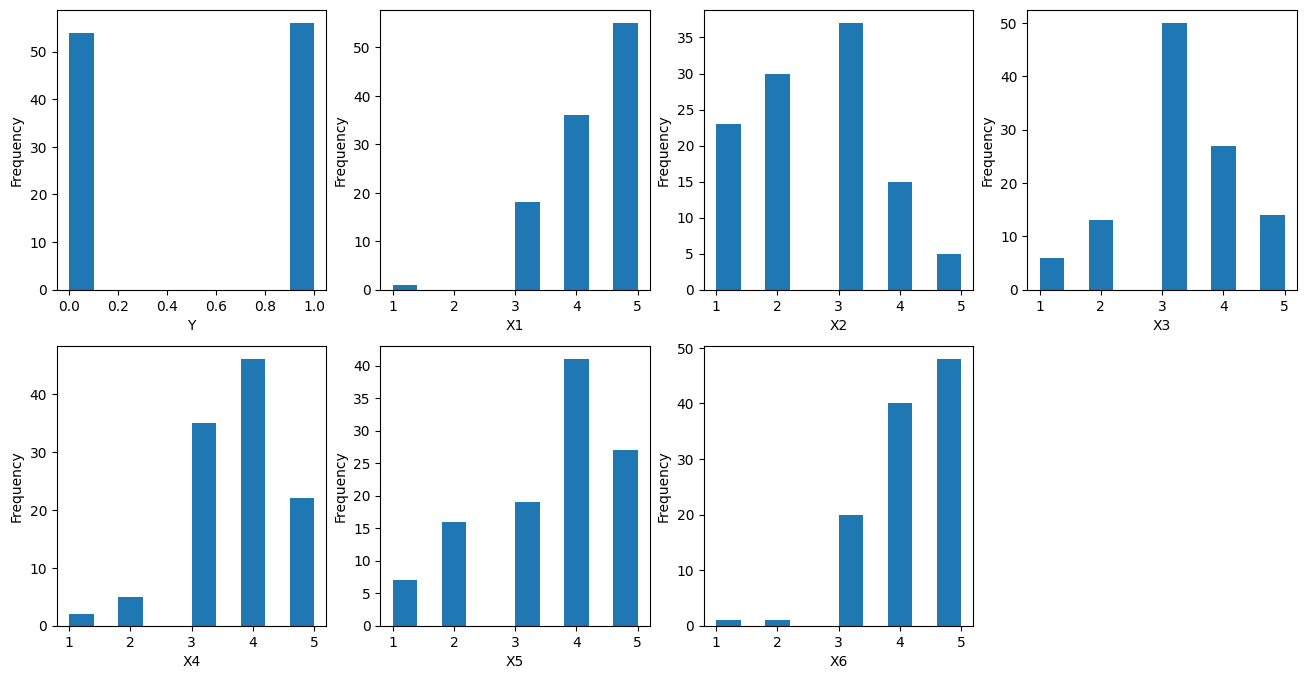

In [9]:
df = X_data
fig = plt.figure(figsize = (16, 8))
i = 0
for column in df:
  sub = fig.add_subplot(2, 4, i + 1)
  sub.set_xlabel(column)
  df[column].plot(kind = 'hist')
  i = i + 1

In [10]:
df['Y'].value_counts()

1    56
0    54
Name: Y, dtype: int64

It seems that target "Y" has almost equal distribution of 0 "Unhappy customer" and 1 "Happy customer"

# Categorical Features vs. Target — Grouped Bar Chart

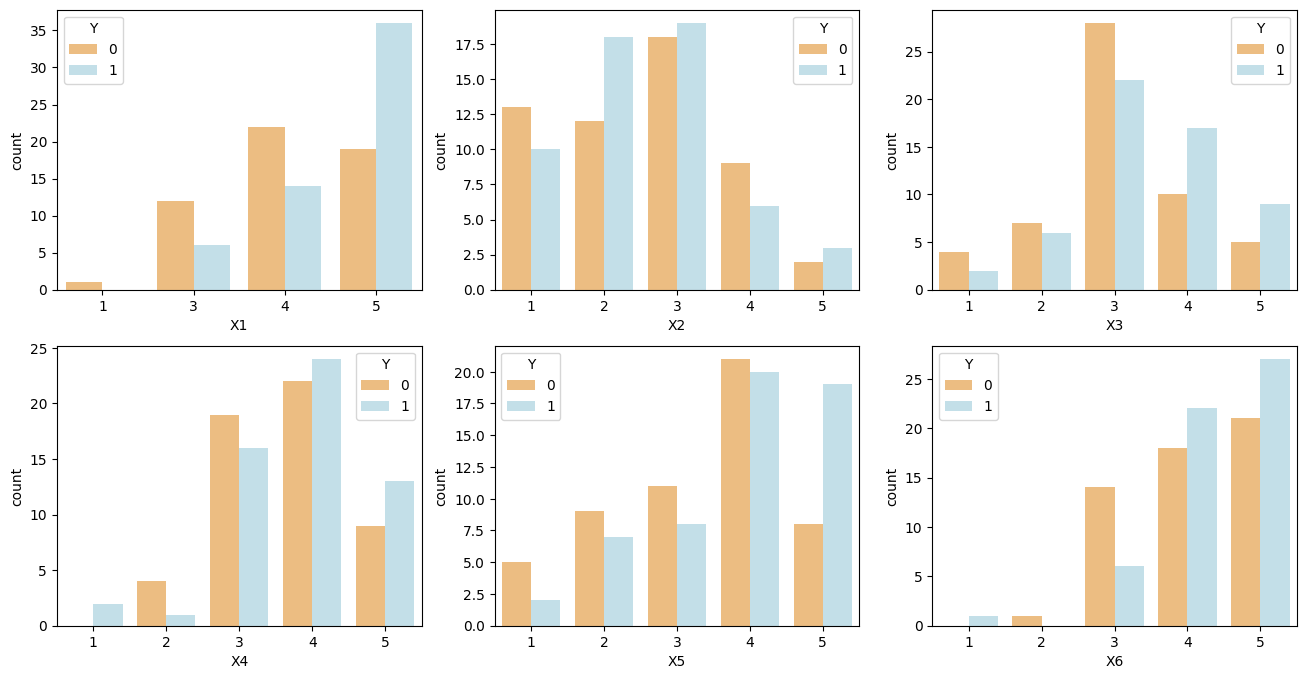

In [11]:
col  = list(df.columns)
cat_list = col[1:]
fig = plt.figure(figsize = (16, 8))
for i in range(len(cat_list)):
  column = cat_list[i]
  sub = fig.add_subplot(2, 3, i + 1)
  chart = sns.countplot(data = df, x = column, hue = 'Y', palette= 'RdYlBu')

This catogorical plot shows how each catogrical feature has distinctly distribution of target's 0 and 1. X5 has distinct distribution of target values 0 and 1. 

# Correlation map

<Axes: >

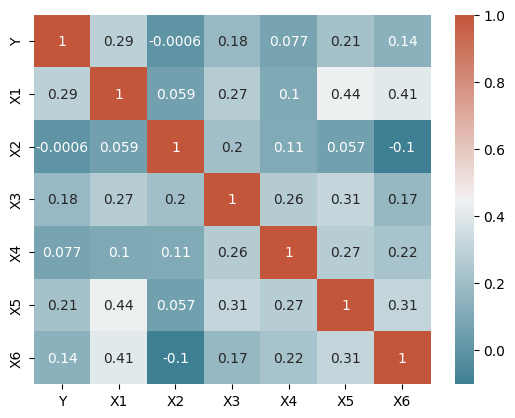

In [12]:
# calculate correlation matrix
corr = X_data.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

The correlation map shows that X1, X5 and X3 are correlated to target. 

# Feature Selection using Recursive Feature Elimination (RFE) method

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X1 = X_data.iloc[:,1:7]  #independent columns
y1 = X_data.iloc[:,0]    #target column i.e Y
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Questions','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print all best features rank wise

  Questions     Score
4        X5  1.959765
0        X1  1.359599
2        X3  1.051679
5        X6  0.342018
3        X4  0.137904
1        X2  0.000019


Above features' ranking shows that X5, X1 and X3 are best featurs. 

---



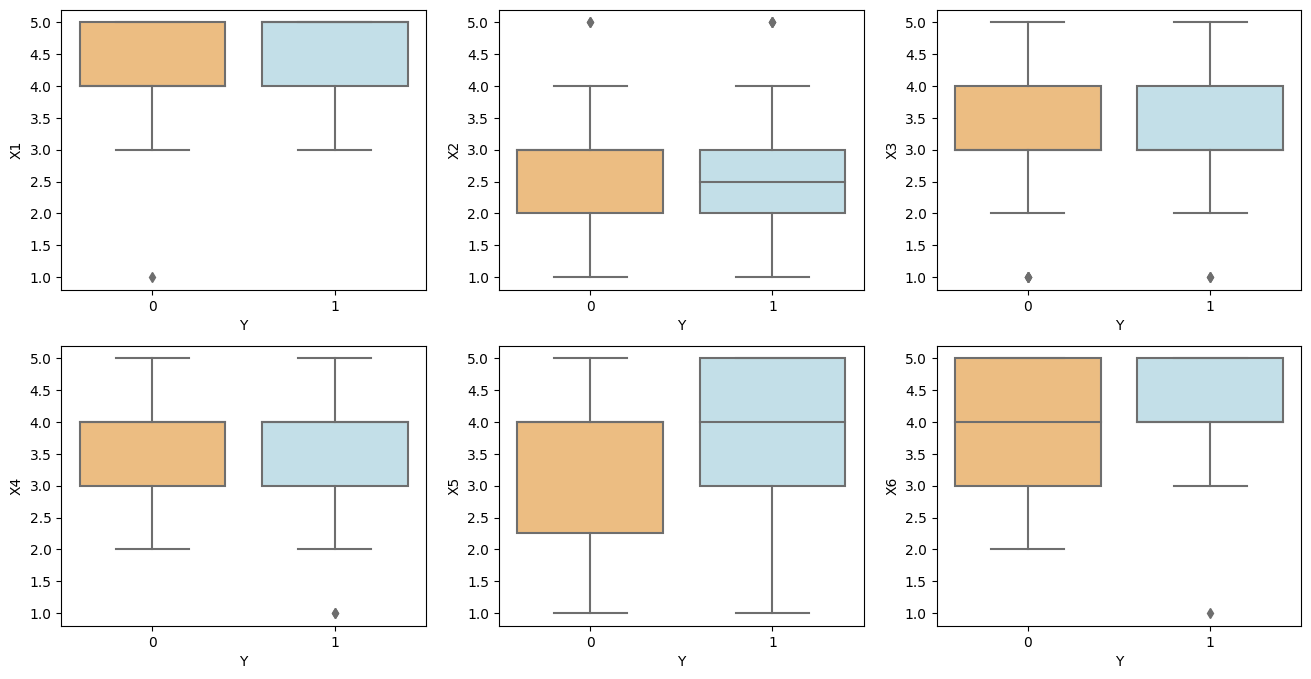

In [14]:
col  = list(df.columns)
cat_list = col[1:]
fig = plt.figure(figsize = (16, 8))
for i in range(len(cat_list)):
  column = cat_list[i]
  sub = fig.add_subplot(2, 3, i + 1)
  sns.boxplot(x = 'Y', y = column, data = df, palette= 'RdYlBu')

Box plot shows how the values of numerical features varies across target groups. For example, we can tell that “X5” have distinct difference when target is 0 vs. target is 1, suggesting that it is an important predictor. 

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# normalizing numeric features and converting back to dataframe
min_max_scaler = preprocessing.MinMaxScaler()
normalized_numeric_feats = min_max_scaler.fit_transform(X1)
X_normalized = normalized_numeric_feats 

In [16]:
X_data2 = pd.DataFrame(X_normalized, columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
y = pd.DataFrame(y1.values, columns=['Y'])

In [17]:
# variance inflation factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = X_data2[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# features to consider removing
considered_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']


# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
0,X1,1.416662
4,X5,1.378845
5,X6,1.298934
2,X3,1.222242
3,X4,1.161726
1,X2,1.077877


In [18]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X_data2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.669224
         Iterations 5
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.034   
Dependent Variable: Y                AIC:              159.2293
Date:               2023-05-27 02:36 BIC:              175.4321
No. Observations:   110              Log-Likelihood:   -73.615 
Df Model:           5                LL-Null:          -76.228 
Df Residuals:       104              LLR p-value:      0.38884 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
-----------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-----------------------------------------------------------------
X1        1.0634     1.0526    1.0102   0.3124   -0.9997   3.1265
X2       -0.6593     0.7317   -0.9011   0.3675   -2.0934   0.7748
X3        0.6140 

# Without selcted features - All features are used for the prediction

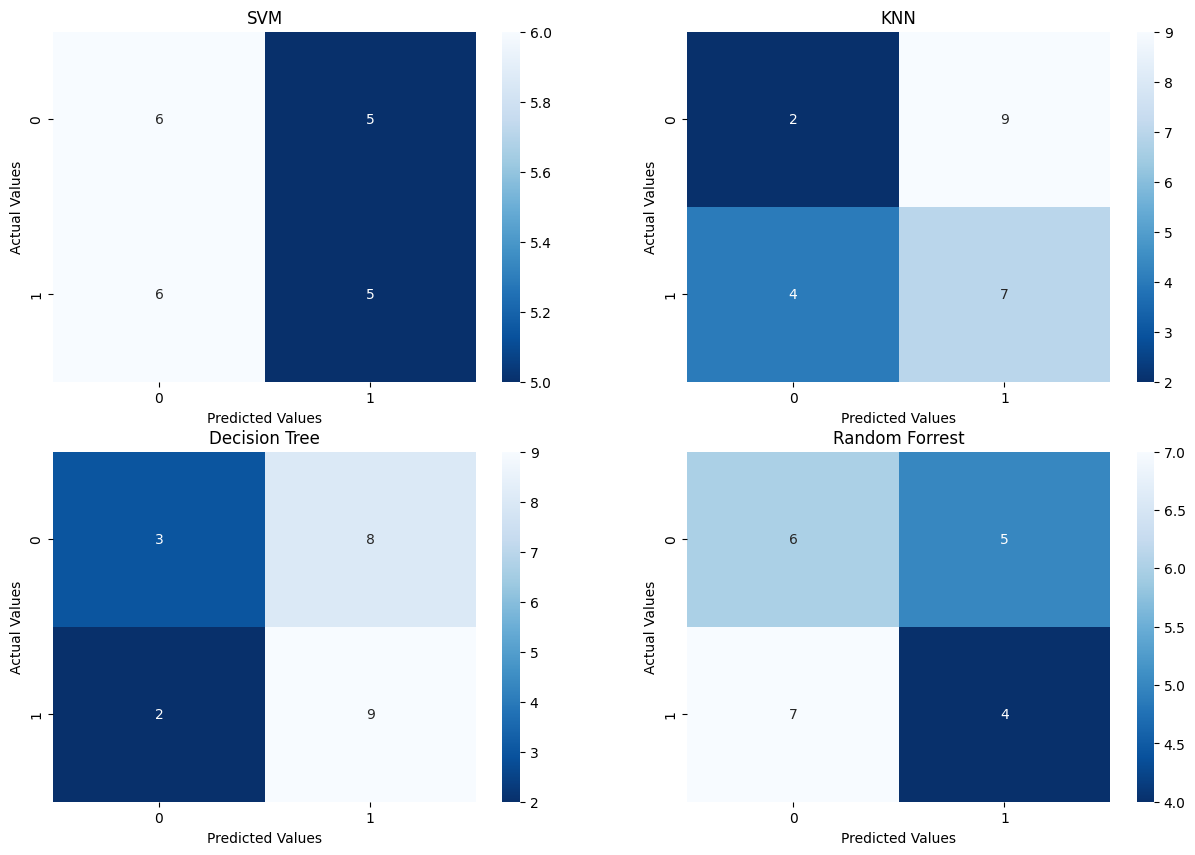

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_data2, np.ravel(y), test_size=0.2, stratify=y)


# machine learning pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


model_pipeline = []

model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())



#Model Evaluation

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


model_list = ['SVM', 'KNN', 'Decision Tree', 'Random Forrest']
acc_list = []
auc_list = []
cm_list = []

for model in model_pipeline:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, _threshold = metrics.roc_curve(y_test, y_pred)
  auc_list.append(round(metrics.auc(fpr, tpr), 2))
  cm_list.append(confusion_matrix(y_test, y_pred))

  #plot confusion matrix

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
  cm = cm_list[i]
  model = model_list[i]
  sub = fig.add_subplot(2, 2, i + 1).set_title(model)
  cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues_r')
  cm_plot.set_xlabel('Predicted Values')
  cm_plot.set_ylabel('Actual Values')
  


In [20]:
# accuracy and auc before features selection
print ('Without Selected Features - All features are used')
result_df = pd.DataFrame({'Model' : model_list, 'Accuracy' : np.round(acc_list, 2), 'AUC' : auc_list})
result_df

Without Selected Features - All features are used


,Model,Accuracy,AUC
0,SVM,0.50,0.50
1,KNN,0.41,0.41
2,Decision Tree,0.55,0.55
3,Random Forrest,0.45,0.45


In [21]:
# Selecting the best features X1 and X5

df_new = X_data2
df_new = df_new.drop('X3', axis=1)
df_new = df_new.drop('X6', axis=1)
df_new = df_new.drop('X4', axis=1)
df_new = df_new.drop('X2', axis=1)
# df_new = df_new.drop('X1', axis=1)
# df_new

# With selected best features - X1 and X5

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_new, np.ravel(y), test_size=0.2, stratify=y)

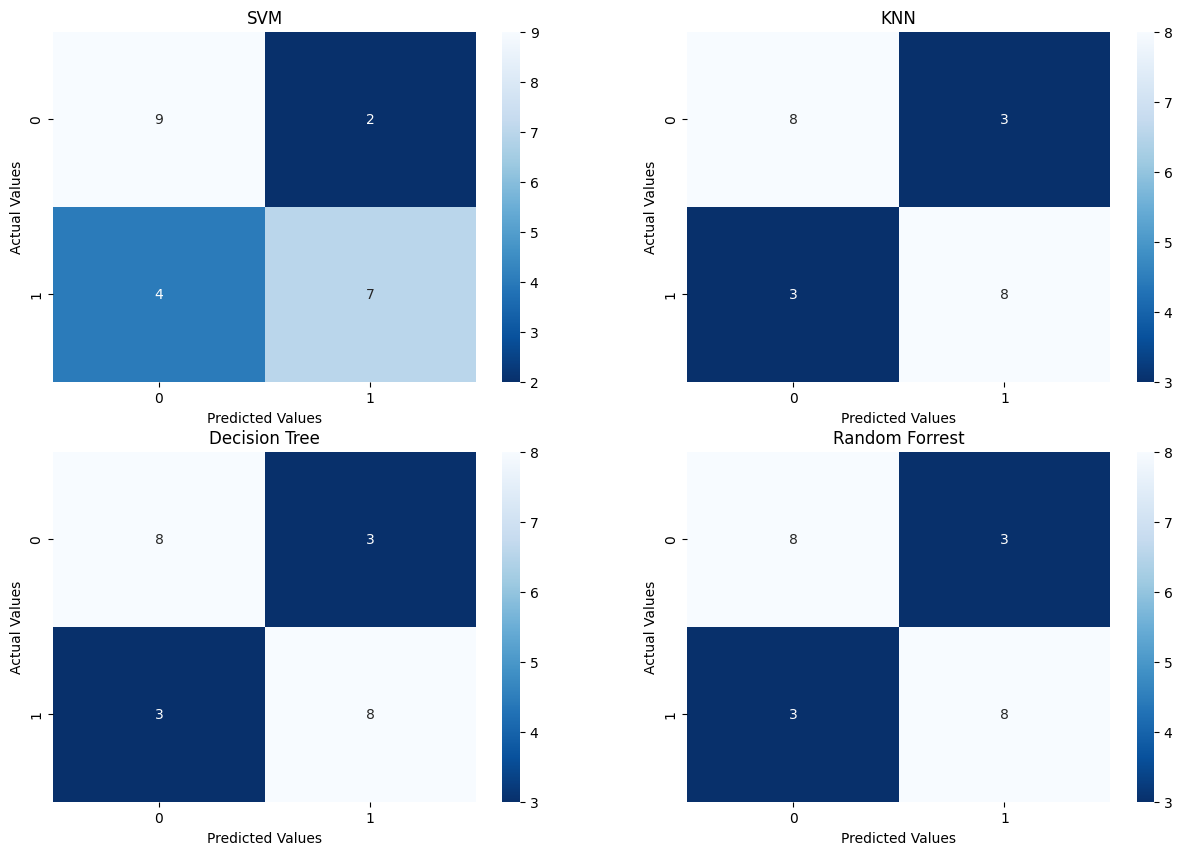

In [29]:
# machine learning pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


model_pipeline = []

model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())



#Model Evaluation

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


model_list = ['SVM', 'KNN', 'Decision Tree', 'Random Forrest']
acc_list = []
auc_list = []
cm_list = []

for model in model_pipeline:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, _threshold = metrics.roc_curve(y_test, y_pred)
  auc_list.append(round(metrics.auc(fpr, tpr), 2))
  cm_list.append(confusion_matrix(y_test, y_pred))

  #plot confusion matrix

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
  cm = cm_list[i]
  model = model_list[i]
  sub = fig.add_subplot(2, 2, i + 1).set_title(model)
  cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues_r')
  cm_plot.set_xlabel('Predicted Values')
  cm_plot.set_ylabel('Actual Values')

In [30]:
# accuracy and auc after features selection
print ('With Selected Features - X1 and X5')
result_df = pd.DataFrame({'Model' : model_list, 'Accuracy' : np.round(acc_list, 2), 'AUC' : auc_list})
result_df

With Selected Features - X1 and X5


,Model,Accuracy,AUC
0,SVM,0.73,0.73
1,KNN,0.73,0.73
2,Decision Tree,0.73,0.73
3,Random Forrest,0.73,0.73
